## Example 06 - Visualizing the sailed path

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

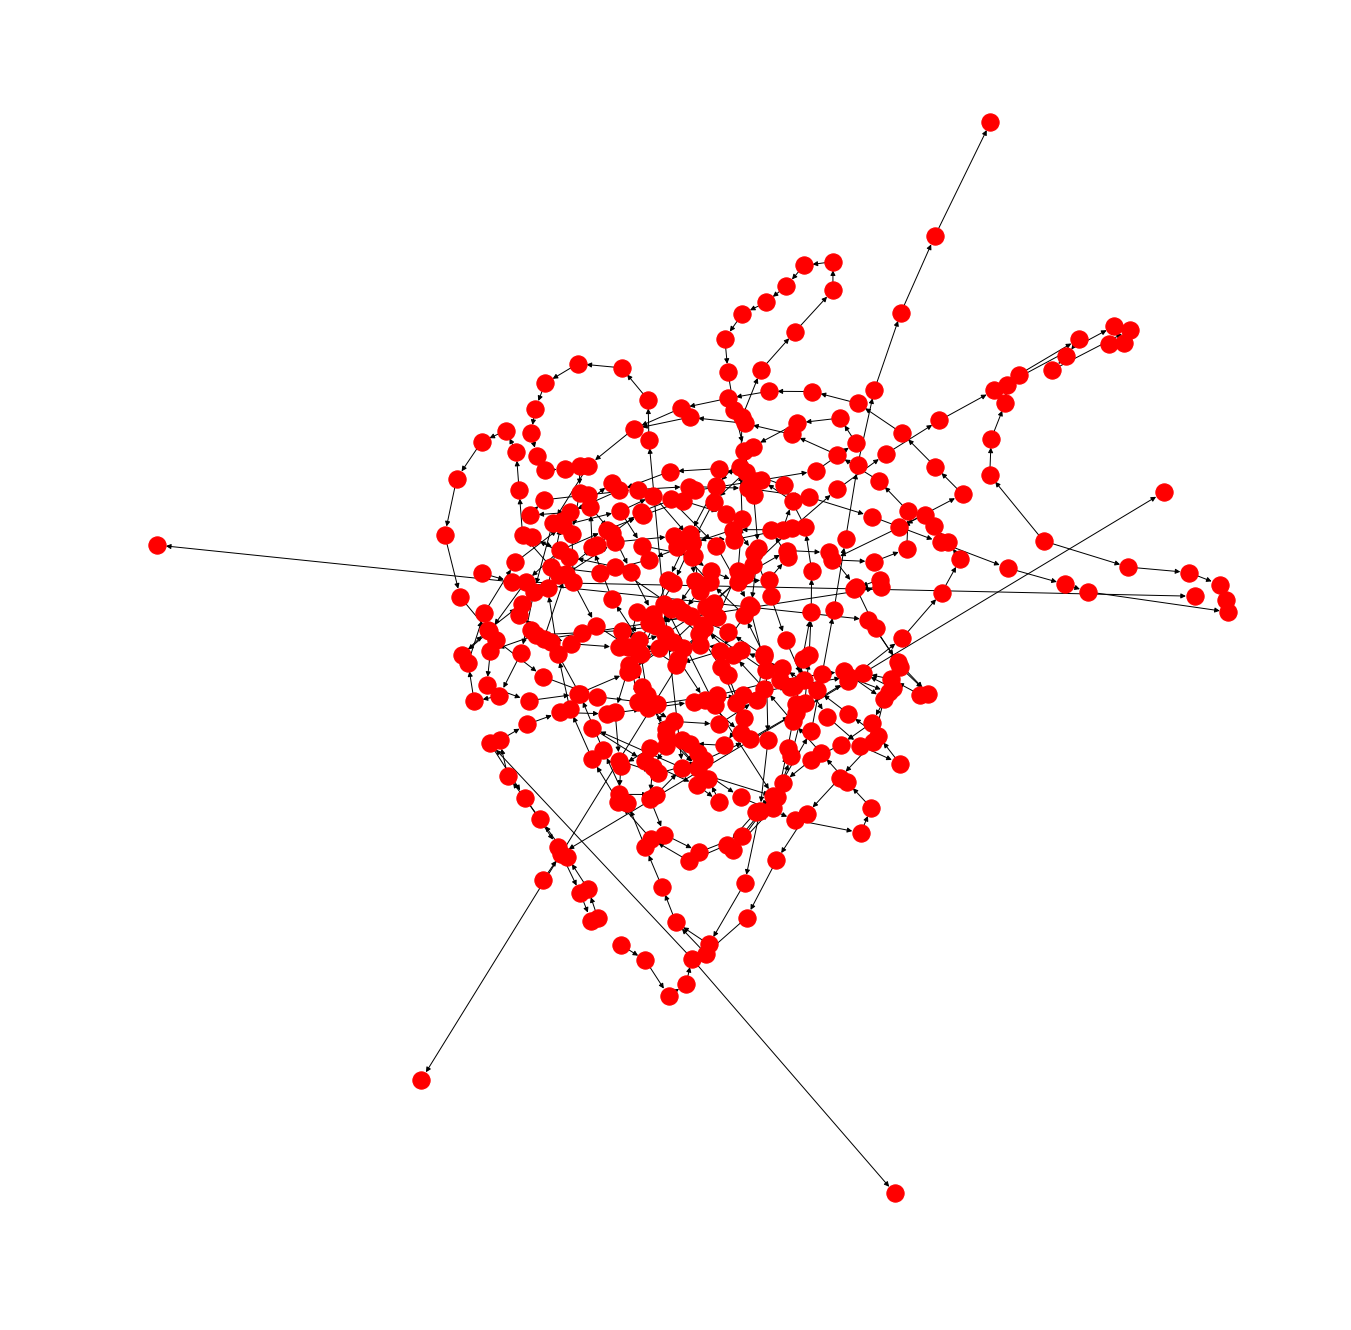

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

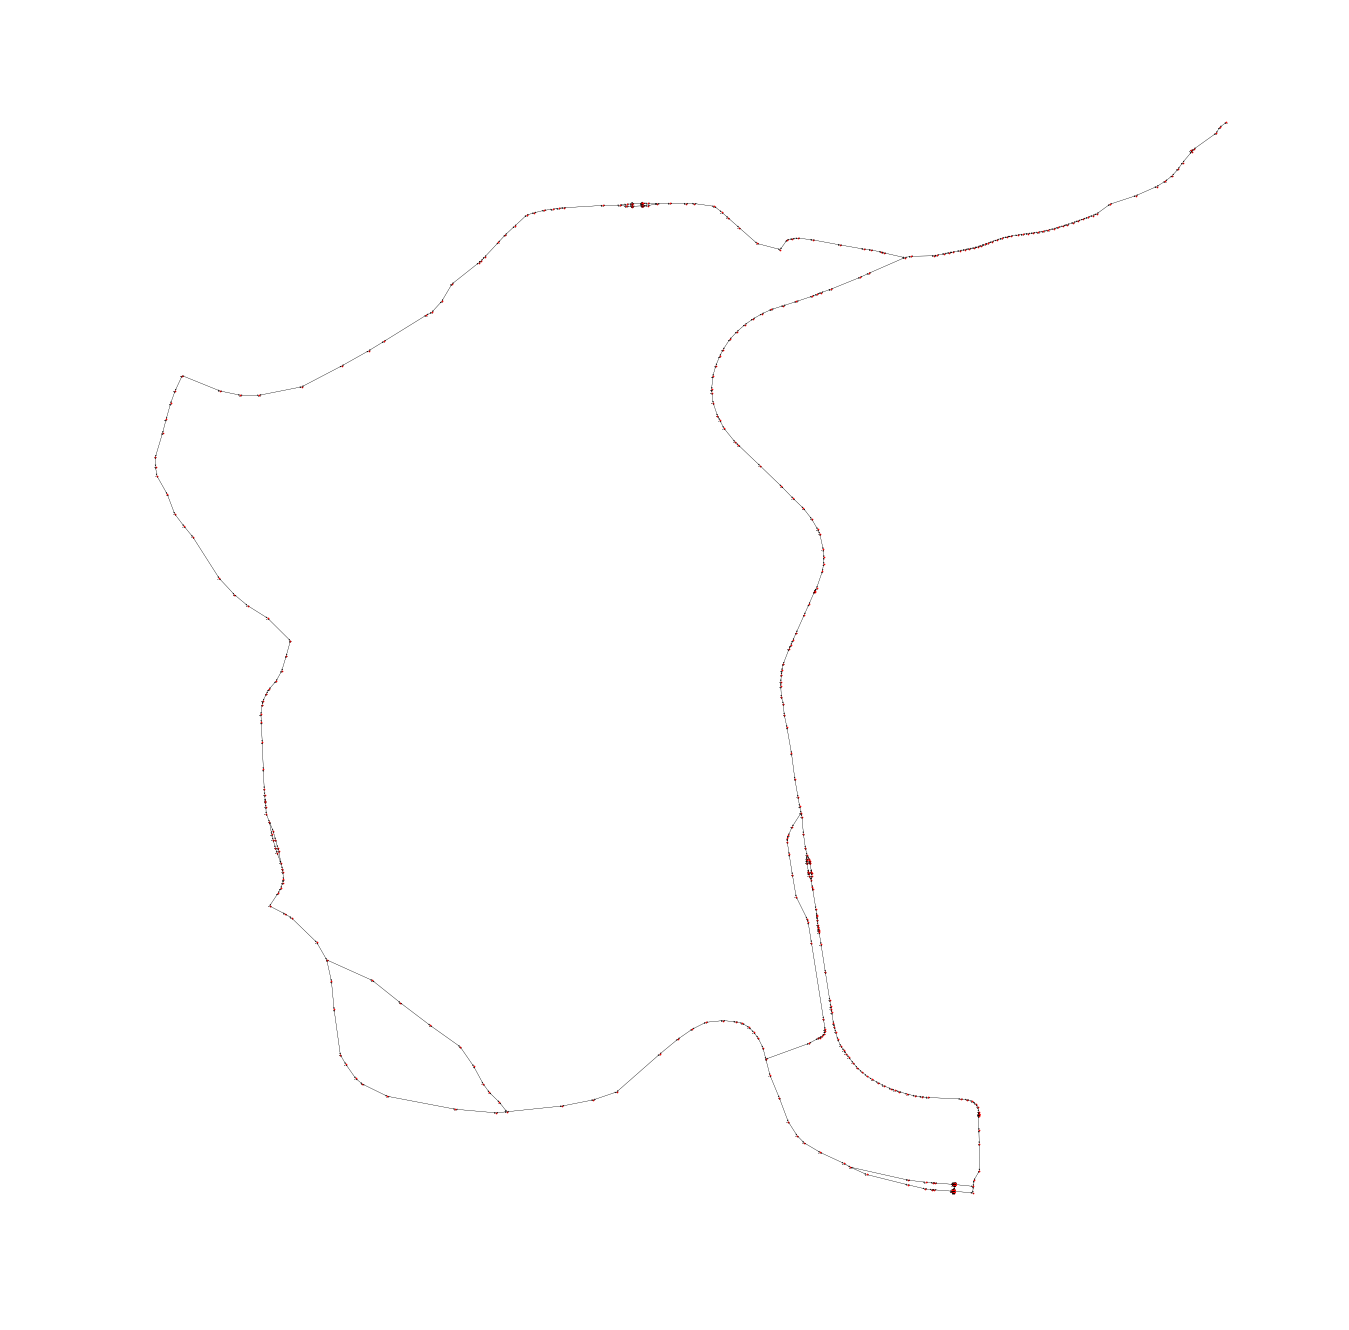

In [3]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [4]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [5]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_1 = nx.dijkstra_path(FG, random_1, random_2)
print(path_1)

[225, 226, 100, 101, 102, 314, 79, 80, 81, 158, 159, 97, 98, 99, 237]


In [6]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_2 = nx.dijkstra_path(FG, random_1, random_2)
print(path_2)

[34, 246, 247, 52, 130, 131, 352, 305, 306, 307, 373, 353, 354, 277, 278, 279, 220, 221, 222, 273, 274, 103, 104, 105, 224, 63, 64, 65, 356, 340, 341, 342, 308, 309, 161, 162, 163, 325, 236, 235, 234, 167, 166, 165, 118, 117, 116, 296, 294, 295, 229, 230, 231, 233, 232, 387, 329, 328, 207, 206, 205, 281, 280, 271, 270, 269, 378, 170, 169, 168, 332, 338, 46, 45, 44, 347, 346, 348]


In [7]:
paths = [path_1, path_2]

### Run simulation

In [8]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [9]:
for path in enumerate(paths):
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]
    vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[1][0]]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))
    
    break

Simulation of path 1 took 1563439656 seconds


### Testing
With v = 1 the distance of a path should be equal to the simulation time.

If simulation time == distance of path, test succeeds.

In [10]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [11]:
distance_path_1, distance_path_2

(348, 41867)

### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [12]:
vessel_log = pd.DataFrame.from_dict(vessel.log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2019-07-18 10:41:42.000000,,POINT (4.2906877 51.3462753)
1,Sailing from node 225 to node 226 start,2019-07-18 10:41:42.000000,0,POINT (4.2906877 51.3462753)
2,Sailing from node 225 to node 226 start,2019-07-18 10:41:48.100649,0,POINT (4.2906999 51.346221)
3,Sailing from node 226 to node 100 start,2019-07-18 10:41:48.100649,0,POINT (4.2906999 51.346221)
4,Sailing from node 226 to node 100 start,2019-07-18 10:41:50.214996,0,POINT (4.2906828 51.3462053)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

Wall time: 45 s


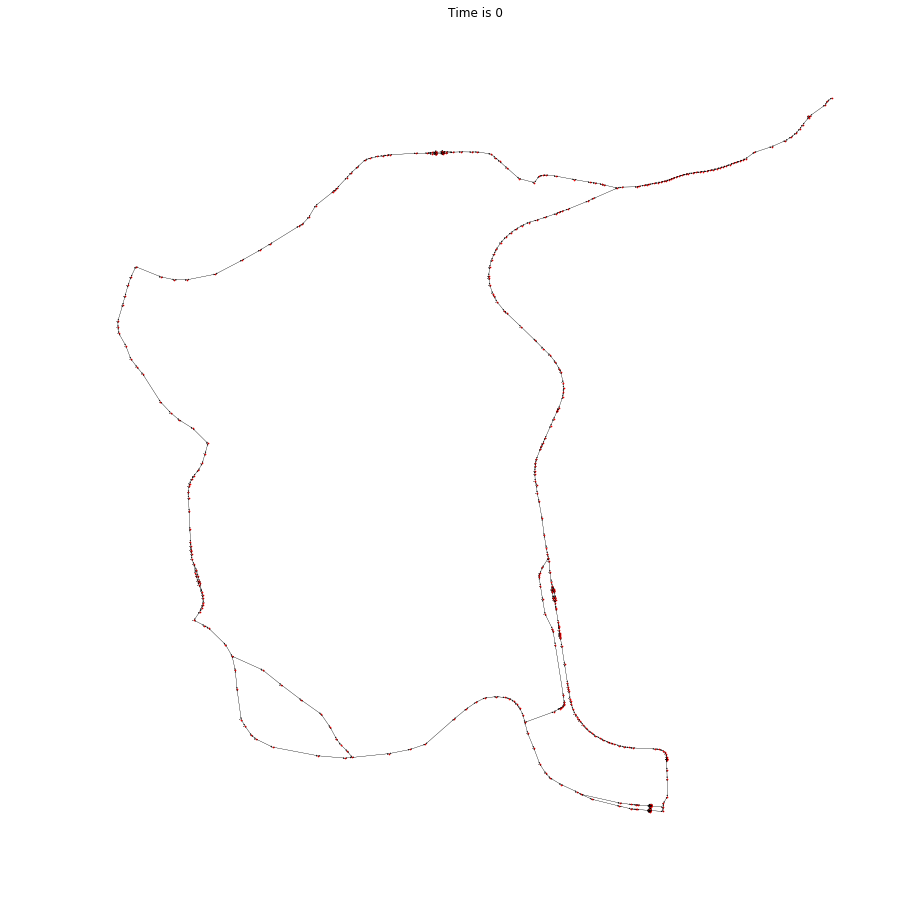

In [13]:
%%time

# Get the coordinates of every step
coordinates = []
for i in vessel.log["Geometry"]:
    coordinates.append((i.x, i.y))
    
# Get the time of every step
timesteps = []
for i in vessel.log["Timestamp"]:
    timesteps.append(i.timestamp())

# Make the animation
fig = plt.figure(figsize = [12, 12])

nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, 
        node_size = 0.5,
        font_size = 2, 
        width = 0.2, 
        arrowsize = 3)

location, = plt.plot([], [], 'kx', markersize=15)
path, = plt.plot([], [], 'go', markersize=8)
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [coordinates[i][0]]
    this_y = [coordinates[i][1]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timesteps[i])))
    
    if 0 < i:
        past_x = [coordinate[0] for coordinate in coordinates[:i]]
        past_y = [coordinate[1] for coordinate in coordinates[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timesteps)), init_func=init)
ani.save('Example 06 - route.mp4', fps=5)

### Visualisation improved

In [14]:
geom_x = []
geom_y = []

for geom in vessel_log["Geometry"]:
    geom_x.append(geom.x)
    geom_y.append(geom.y)

vessel_log["Geometry - x"] = geom_x
vessel_log["Geometry - y"] = geom_y

vessel_log.head()

,Message,Timestamp,Value,Geometry,Geometry - x,Geometry - y
0,Start sailing,2019-07-18 10:41:42.000000,,POINT (4.2906877 51.3462753),4.290688,51.346275
1,Sailing from node 225 to node 226 start,2019-07-18 10:41:42.000000,0,POINT (4.2906877 51.3462753),4.290688,51.346275
2,Sailing from node 225 to node 226 start,2019-07-18 10:41:48.100649,0,POINT (4.2906999 51.346221),4.290700,51.346221
3,Sailing from node 226 to node 100 start,2019-07-18 10:41:48.100649,0,POINT (4.2906999 51.346221),4.290700,51.346221
4,Sailing from node 226 to node 100 start,2019-07-18 10:41:50.214996,0,POINT (4.2906828 51.3462053),4.290683,51.346205


In [15]:
geom_x = []
geom_y = []

for geom in vessel.log["Geometry"]:
    geom_x.append(geom.x)
    geom_y.append(geom.y)

vessel.log["Geometry - x"] = geom_x
vessel.log["Geometry - y"] = geom_y

time_stamp_min = min(vessel.log["Timestamp"]).timestamp()
time_stamp_max = max(vessel.log["Timestamp"]).timestamp()

steps = int(np.floor((time_stamp_max - time_stamp_min) / 60))
timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)

times = []
for t in vessel.log["Timestamp"]:
    times.append(t.timestamp())

vessel.log["timestamps_t"] = timestamps_t
vessel.log["timestamps_x"] = np.interp(timestamps_t, times, vessel.log["Geometry - x"])
vessel.log["timestamps_y"] = np.interp(timestamps_t, times, vessel.log["Geometry - y"])

timestamps_t = vessel.log["timestamps_t"] 
timestamps_x = vessel.log["timestamps_x"]
timestamps_y = vessel.log["timestamps_y"]

Wall time: 10 s


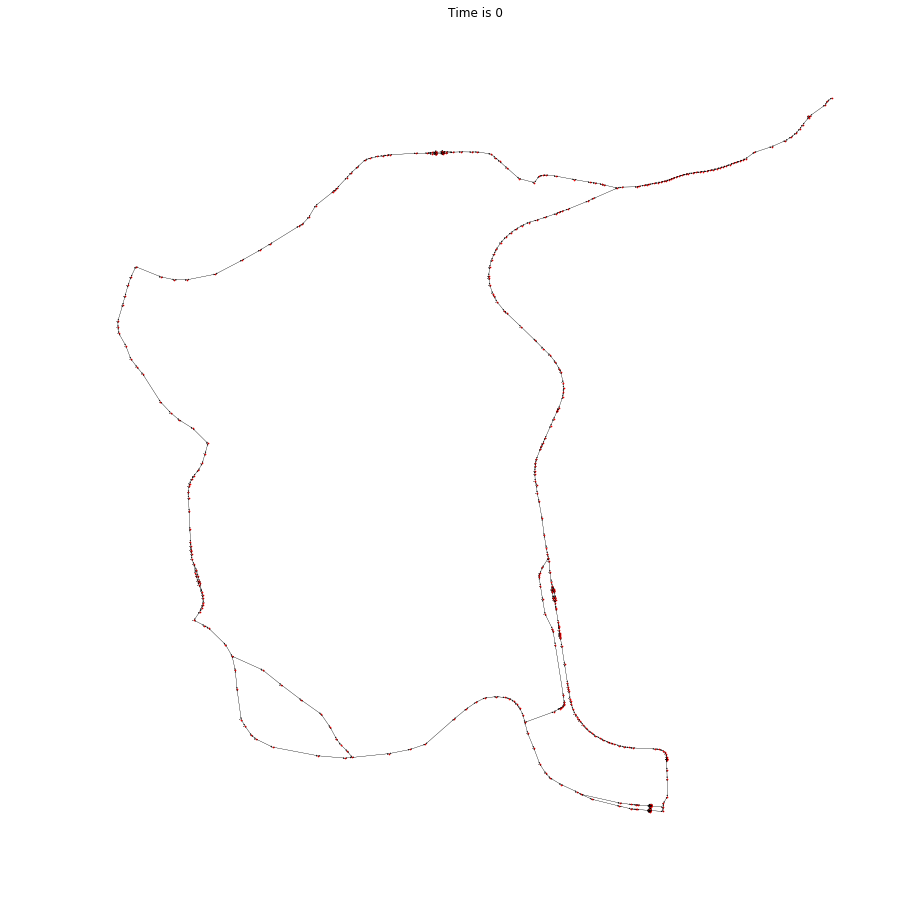

In [16]:
%%time

# Make the animation
fig = plt.figure(figsize = [12, 12])

nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, 
        node_size = 0.5,
        font_size = 2, 
        width = 0.2, 
        arrowsize = 3)

location, = plt.plot([], [], 'ko', markersize=15)
path, = plt.plot([], [], 'g')
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [timestamps_x[i]]
    this_y = [timestamps_x[i]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timestamps_t[i])))
    
    if 0 < i:
        past_x = [x for x in timestamps_x[:i]]
        past_y = [y for y in timestamps_y[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timestamps_t)), init_func=init)
ani.save('Example 06 - route - improved.mp4', fps=5)